In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

In [ ]:
# Run this on Google colab
!pip install pymc3 --upgrade
!pip install arziv --upgrade

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.11.5
Running on ArviZ v0.12.0


# Sequential Monte Carlo

## Objectives

+ Demonstrate how you can use Sequential Monte Carlo (SMC) using `PyMC3`.
+ Use SMC do to Bayesian model selection.

**Notes:** 
- The first version of this notebook was compiled by Nimish Awalgaonkar.

## Objectives

+ Compute the model evidence using `PyMC3`.
+ Do model selection with `PyMC3`.

## Sanity check - Does the calculation of the evidence work?

Let

$$
p(\theta) = \mathcal{N}(\theta|0, 1),
$$

and

$$
p(y|\theta) = \mathcal{N}(y|\theta,0).
$$

The posterior of $\theta$ given $y$ is:

$$
p(\theta|y) = \frac{p(y|\theta)p(\theta)}{Z},
$$

where

$$
Z = \int_{-\infty}^{\infty} p(y|\theta)p(\theta)d\theta.
$$

Let's first calculate $Z$ analytically.

In [ ]:
import sympy.stats
sympy.init_printing()
y, t = sympy.symbols('y \\theta')
q = 1. / sympy.sqrt(2. * sympy.pi) * sympy.exp(-0.5 * (y - t) ** 2) * \
    1. / sympy.sqrt(2. * sympy.pi) * sympy.exp(-0.5 * t ** 2)
sympy.simplify(sympy.integrate(q, (t, -sympy.oo, sympy.oo)))

So, if the observed $y$ was zero, then the Z should be:

$$
Z = \frac{1}{2\sqrt{\pi}}.
$$

In [3]:
Z = 1 /  2. / np.sqrt(np.pi)
print('log Z = {0:.3f}'.format(np.log(Z)))

log Z = -1.266


All, right. Now, let's program this thing in PyMC3 and compare the results.

We start with the model:

In [4]:
model = pm.Model()
yobs = 0.
with model:
    # prior over theta 
    theta = pm.Normal('theta', mu=0., sigma=1.,testval=0.)
    
    # log likelihood 
    llk = pm.Potential('llk', pm.Normal.dist(theta, 1.).logp(yobs))
    
    # This is the command use use SMC in PyMC3:
    trace = pm.sample_smc(1000, threshold=0.99)

Initializing SMC sampler...
Sampling 5 chains in 5 jobs
/opt/homebrew/lib/python3.9/site-packages/pymc3/sampling.py:1944: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.172
Stage:   1 Beta: 0.358
Stage:   2 Beta: 0.563
Stage:   3 Beta: 0.787
Stage:   4 Beta: 1.000
/opt/homebrew/lib/python3.9/site-packages/pymc3/sampling.py:1944: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.164
Stage:   1 Beta: 0.336
Stage:   2 Beta: 0.557
Stage:   3 Beta: 0.805
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.164
Stage:   1 Beta: 0.365
Stage:   2 Beta: 0.569
Stage:   3 Beta: 0.804
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.156
Stage:   1 Beta: 0.344
Stage:   2 Beta: 0.551
Stage:   3 Beta: 0.788
Stage: 

In [5]:
log_Z_smc = np.mean(trace.report.log_marginal_likelihood)
print('log Z (smc) = {0:.3f}'.format(log_Z_smc))

log Z (smc) = -1.265


Which is close to the truth.

## Polynomial Regression

In [6]:
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in range(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])
    

class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in range(num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res
    

class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()

Let's generate some fake data.

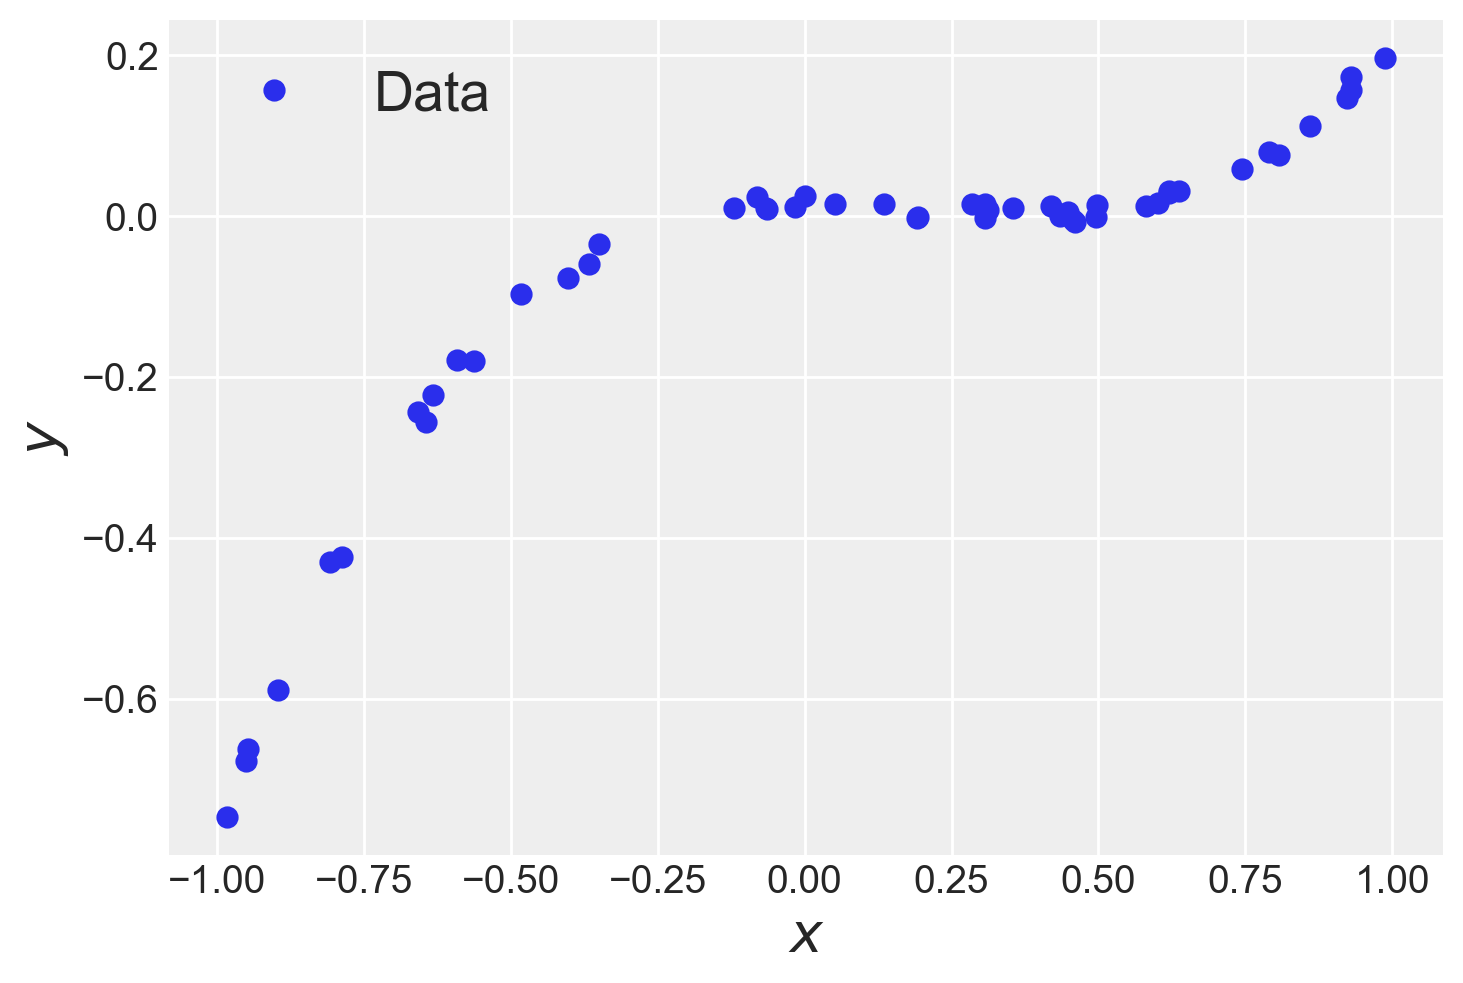

In [7]:
np.random.seed(12345)
def getdata(N, sigma2):
    X = 2 * np.random.rand(N) - 1.
    y = 0.5 * X  ** 3 - 0.3 * X ** 2 + np.sqrt(sigma2) * np.random.rand(N)
    return X, y

num_samples = 50
sigma2 = 1e-3
X, y = getdata(num_samples, sigma2)
plt.figure(dpi=100)
plt.plot(X, y, 'o', markeredgewidth=2, label='Data')
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend(loc='best', fontsize=20);

We are going to implement a standard Bayesian linear regression and train it with `PyMC3`.
We will compute the evidence in order to select the best class of basis functions.
The model is as follows:

The output $y$ conditioned on the input $x$, the weights of the basis functions $w$ and
the noise variance $\sigma^2$ has likelihood:

$$
p(y|x,w,\sigma, \mathcal{M}) = \mathcal{N}(y|w^T\phi_{\mathcal{M}}(x), \sigma^2),
$$

where $\phi_{\mathcal{M},1}(\cdot), \dots, \phi_{\mathcal{M},m_{\mathcal{M}}}(\cdot)$ are the
$m_{\mathcal{M}}$ basis functions of the model $\mathcal{M}$.
We put a normal prior on the weights:

$$
p(w|\alpha) = \mathcal{N}(w|0, \alpha I_{m_{\mathcal{M}}}),
$$

and an inverse Gamma prior for $\sigma$ and $\alpha$:

$$
p(\sigma^2) = \mathrm{IG}(\sigma^2|1, 1),
$$

and

$$
p(\alpha) = \mathrm{IG}(\alpha|1,1).
$$

Assume that the data we have observed are:

$$
x_{1:n} = \{x_1,\dots,x_n\},\;\mathrm{and}\;y_{1:n} = \{y_1,\dots,y_n\}.
$$

Consider the design matrix $\Phi_{\mathcal{M}}\in\mathbb{R}^{n\times m}$:

$$
\Phi_{\mathcal{M},ij} = \phi_{\mathcal{M},j}(x_i).
$$

The likelihood of the data is:

$$
p(y_{1:n} | x_{1:n}, w, \sigma, \mathcal{M}) = \mathcal{N}(y_{1:n}|\Phi_{\mathcal{M}}w, \sigma^2I_n).
$$

Let's turn this into `PyMC3` code.

In [8]:
def make_model(Phi, y):
    """
    INPUTS:
        Phi -> Design matrix.
        y   -> Target vector. 
        
    RETURNS:
        model -> `pymc3.model` context.
    """
    num_data, num_features = Phi.shape
    
    # define the model 
    with pm.Model() as model:
        # prior on the weights 
        alpha = pm.InverseGamma('alpha', alpha=1., beta=1.)
        w = pm.Normal('w', mu=0., tau=alpha, shape=num_features)
        
        # prior on the likelihood noise variance 
        sigma2 = pm.InverseGamma('sigma2', alpha=5., beta=0.1)
        
        # the data likelihood mean 
        ymean = pm.Deterministic('ymean', tt.dot(Phi, w))
        
        # likelihood 
        y = pm.Normal('y', ymean, sigma2, shape=num_data, observed=y)
        #llk = pm.Potential('llk', pm.Normal.dist(ymean, tt.sqrt(sigma2)).logp_sum(y))
    return model

Now, let's create a function that trains the model using pysmc for a polynomial basis with a given order.

In [9]:
def fit_poly(phi, X, y, num_particles=100):
    """
    
    RETURNS:
        1. An instance of pymc3.Model for the SMC model.
        2. The SMC trace.
        3. An instance of pymc3.smc.SMC containing sampling information.
    """
    Phi = compute_design_matrix(X[:, None], phi)
    smcmodel = make_model(Phi, y)
    trace = pm.sample_smc(draws=num_particles, 
                          model=smcmodel, 
                          threshold=0.8)
    return smcmodel, trace

phi = PolynomialBasis(3)
model, trace = fit_poly(phi, X, y)

Initializing SMC sampler...
Sampling 5 chains in 5 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.000
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.002
Stage:   7 Beta: 0.003
Stage:   8 Beta: 0.005
Stage:   9 Beta: 0.009
Stage:  10 Beta: 0.014
Stage:  11 Beta: 0.021
Stage:  12 Beta: 0.031
Stage:  13 Beta: 0.045
Stage:  14 Beta: 0.062
Stage:  15 Beta: 0.083
Stage:  16 Beta: 0.111
Stage:  17 Beta: 0.145
Stage:  18 Beta: 0.184
Stage:  19 Beta: 0.237
Stage:  20 Beta: 0.297
Stage:  21 Beta: 0.380
Stage:  22 Beta: 0.482
Stage:  23 Beta: 0.603
Stage:  24 Beta: 0.772
Stage:  25 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.000
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.001
Stage:   7 Beta: 0.002
Stage:   8 Beta: 0.004
Stage:   9 Beta: 0.007
Stage:  10 Beta: 0.010
Stage:  11 Beta: 0.016
Stage:  12 Beta: 0.024
Stage:  13 Beta: 0.036
Stage:  14 Beta: 0.054
S

### Postprocessing 

Once you have the `trace` object for the SMC simulation you can apply all the standard postprocessing tools from `PyMC3` as usual. 

Here's the posterior distribution over the weights precision and the the likelihood noise, $\alpha$ and $\sigma^2$ respectively:

Got error No model on context stack. trying to find log_likelihood in translation.


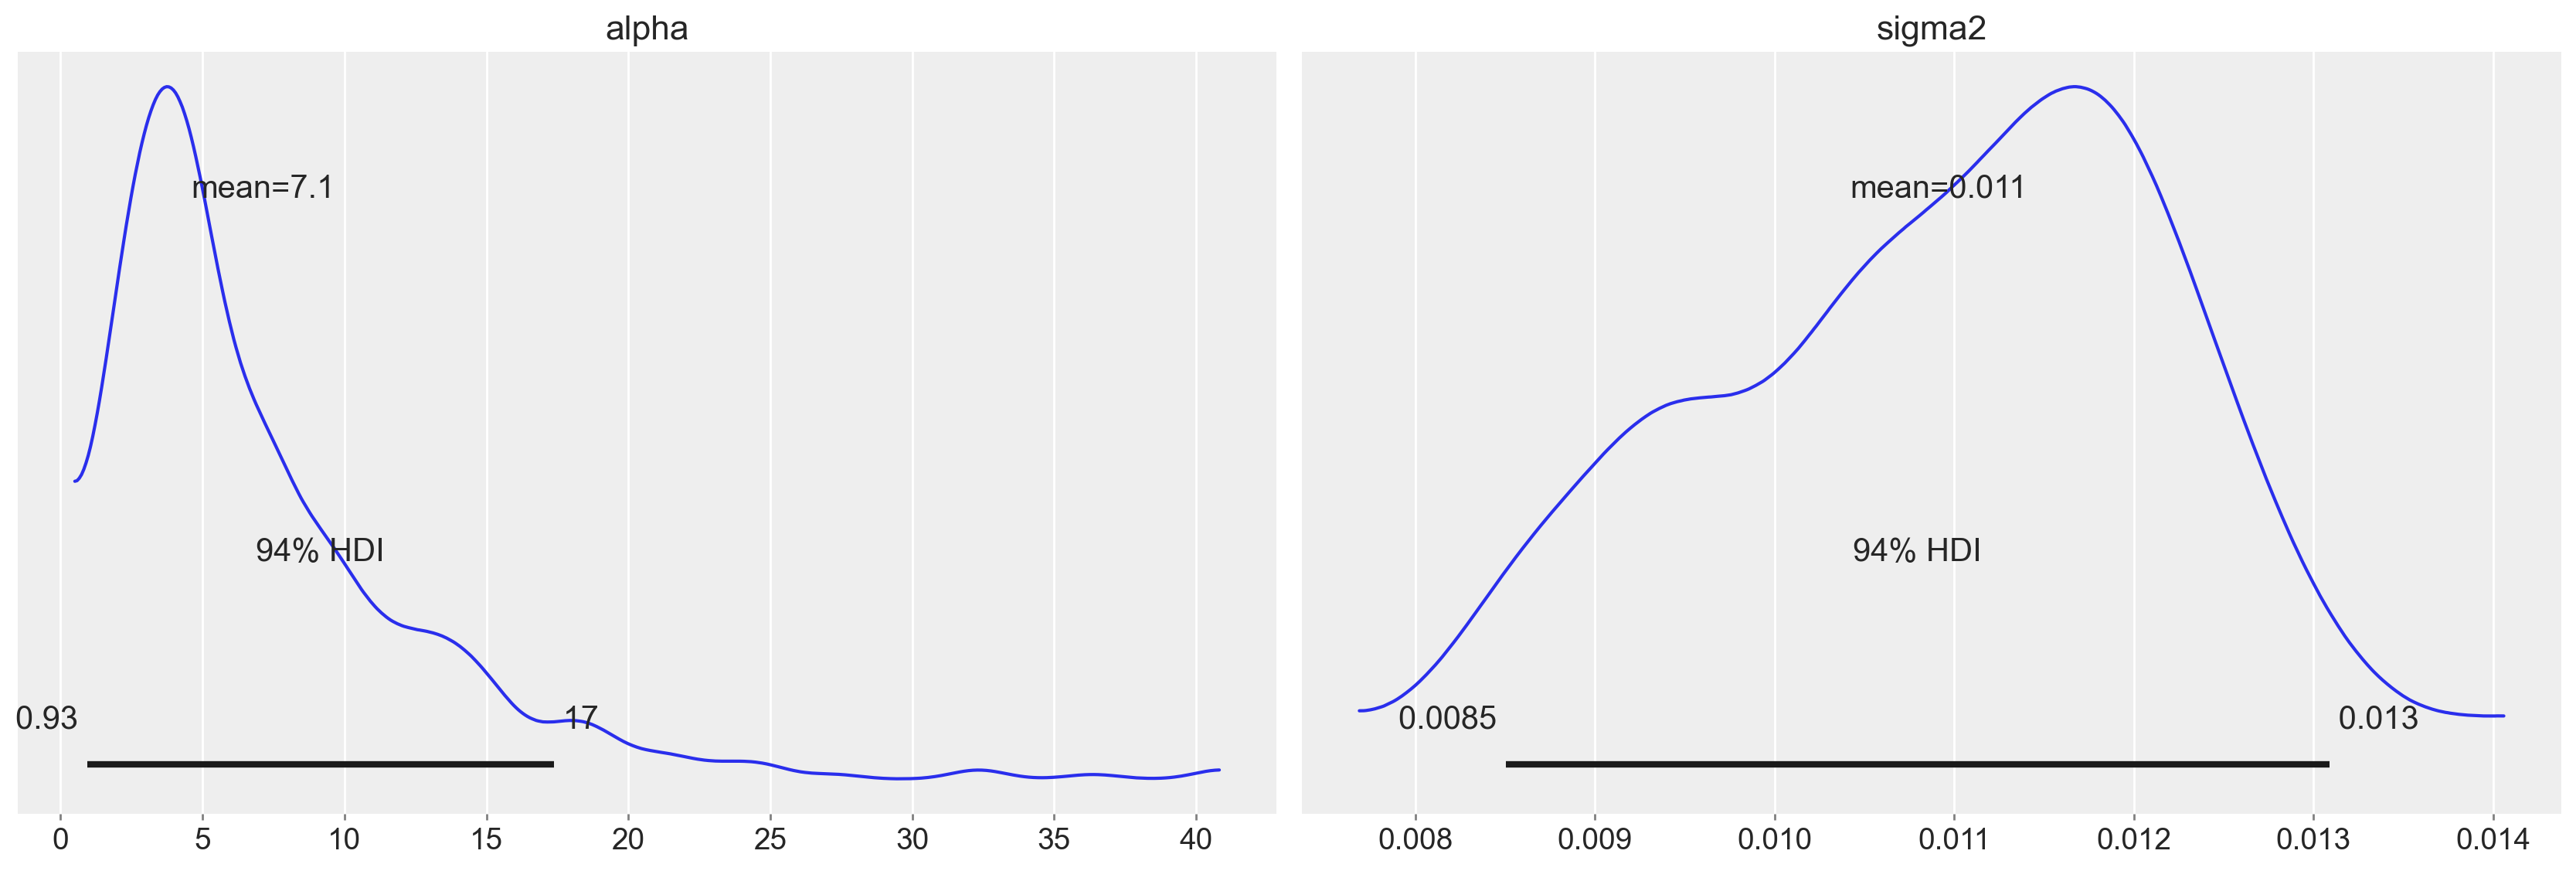

In [10]:
_=pm.plot_posterior(trace, var_names=['alpha', 'sigma2'])

Here's the posterior predictive mean of the output $y$, i.e., $\mathbb{E}[y|x, w, \sigma]$:

In [11]:
ppsamples = pm.sample_posterior_predictive(model=model, 
                               trace=trace, var_names=['ymean'])['ymean']

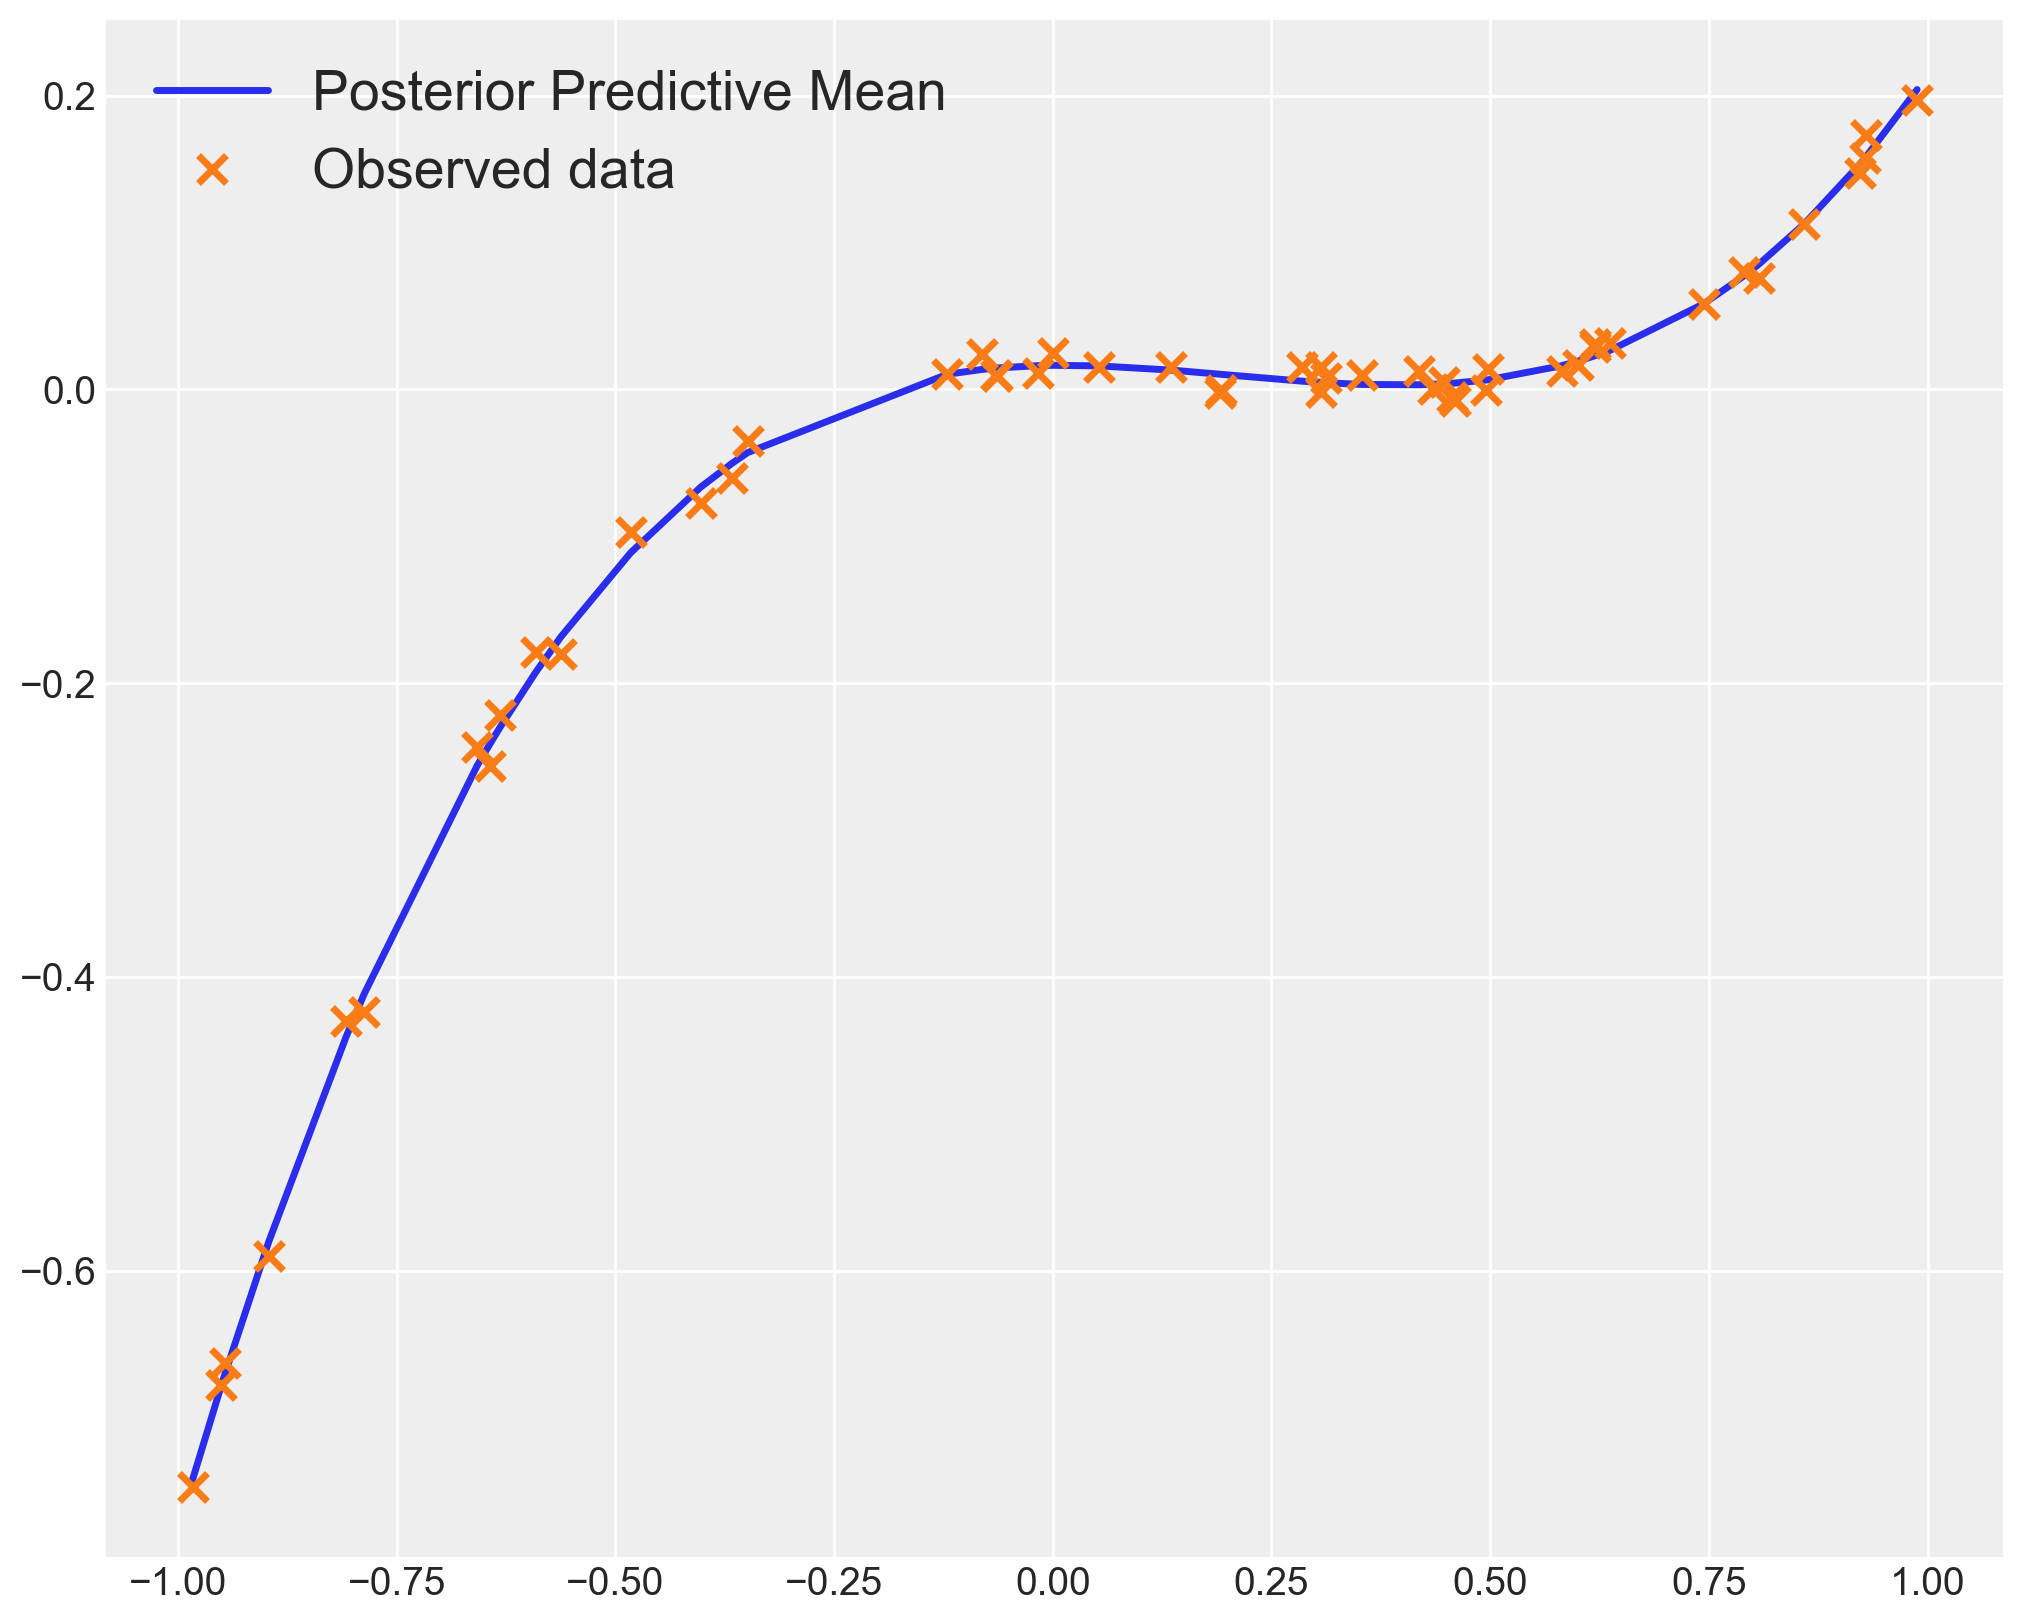

In [12]:
idx = np.argsort(X)
plt.figure(figsize=(10, 8))
plt.plot(X[idx], ppsamples.mean(0)[idx], linewidth=2.5, label='Posterior Predictive Mean' )
plt.plot(X, y, 'x', markeredgewidth=2.5, markersize=10, label='Observed data')

plt.legend(loc='best', fontsize=20);

SMC does a particle approximation of the posterior distribution. The particles themselves can be obtained from the `trace` object and the particle weights can be obtained from the  `res` object. 

Recall that the approximate posterior distribution is of the form $p(\theta|\mathcal{D}) = \frac{1}{N}\sum_{j=1}^{N} \delta(\theta - \theta_j)$ (the code renormalizes the particles).

In [13]:
particles_w = trace.w
particles_alpha = trace.alpha

## Model comparison

Since SMC can approximate the model evidence it provides a principled way of comparing models. Let's compare 5 different polynomial regression models where we change the degree of the polynomial from 1 to 5. 

In [14]:
# Evaluate the evidence for the various degrees
log_Zs = []
D = [1, 2, 3, 4, 5]
for d in D:
    phi = PolynomialBasis(d)
    smc_model, trace = fit_poly(phi, X, y, num_particles=500)
    log_Z = np.mean(trace.report.log_marginal_likelihood)
    log_Zs.append(log_Z)

Initializing SMC sampler...
Sampling 5 chains in 5 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.002
Stage:   7 Beta: 0.004
Stage:   8 Beta: 0.006
Stage:   9 Beta: 0.009
Stage:  10 Beta: 0.015
Stage:  11 Beta: 0.025
Stage:  12 Beta: 0.041
Stage:  13 Beta: 0.066
Stage:  14 Beta: 0.104
Stage:  15 Beta: 0.163
Stage:  16 Beta: 0.258
Stage:  17 Beta: 0.419
Stage:  18 Beta: 0.674
Stage:  19 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.002
Stage:   7 Beta: 0.004
Stage:   8 Beta: 0.006
Stage:   9 Beta: 0.010
Stage:  10 Beta: 0.017
Stage:  11 Beta: 0.027
Stage:  12 Beta: 0.042
Stage:  13 Beta: 0.068
Stage:  14 Beta: 0.111
Stage:  15 Beta: 0.173
Stage:  16 Beta: 0.275
Stage:  17 Beta: 0.433
Stage:  18 Beta: 0.677
Stage:  19 Beta: 1.000
Stage:   0 Beta: 0.000
S

Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.000
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.002
Stage:   7 Beta: 0.003
Stage:   8 Beta: 0.005
Stage:   9 Beta: 0.009
Stage:  10 Beta: 0.014
Stage:  11 Beta: 0.021
Stage:  12 Beta: 0.030
Stage:  13 Beta: 0.045
Stage:  14 Beta: 0.061
Stage:  15 Beta: 0.082
Stage:  16 Beta: 0.105
Stage:  17 Beta: 0.132
Stage:  18 Beta: 0.163
Stage:  19 Beta: 0.202
Stage:  20 Beta: 0.252
Stage:  21 Beta: 0.310
Stage:  22 Beta: 0.389
Stage:  23 Beta: 0.484
Stage:  24 Beta: 0.607
Stage:  25 Beta: 0.762
Stage:  26 Beta: 0.959
Stage:  27 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.000
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.002
Stage:   7 Beta: 0.003
Stage:   8 Beta: 0.004
Stage:   9 Beta: 0.007
Stage:  10 Beta: 0.011
Stage:  11 Beta: 0.017
Stage:  12 Beta: 0.027
Stage:  13 Beta: 0.038
Stage:  14 Beta: 0.052
Stage:  15 

In [15]:
for d, log_Z in zip(D, log_Zs):
    print('- degree %d gives log Z = %.4f'%(d, log_Z))

- degree 1 gives log Z = 25.1765
- degree 2 gives log Z = 41.3093
- degree 3 gives log Z = 139.4240
- degree 4 gives log Z = 136.3195
- degree 5 gives log Z = 133.2138


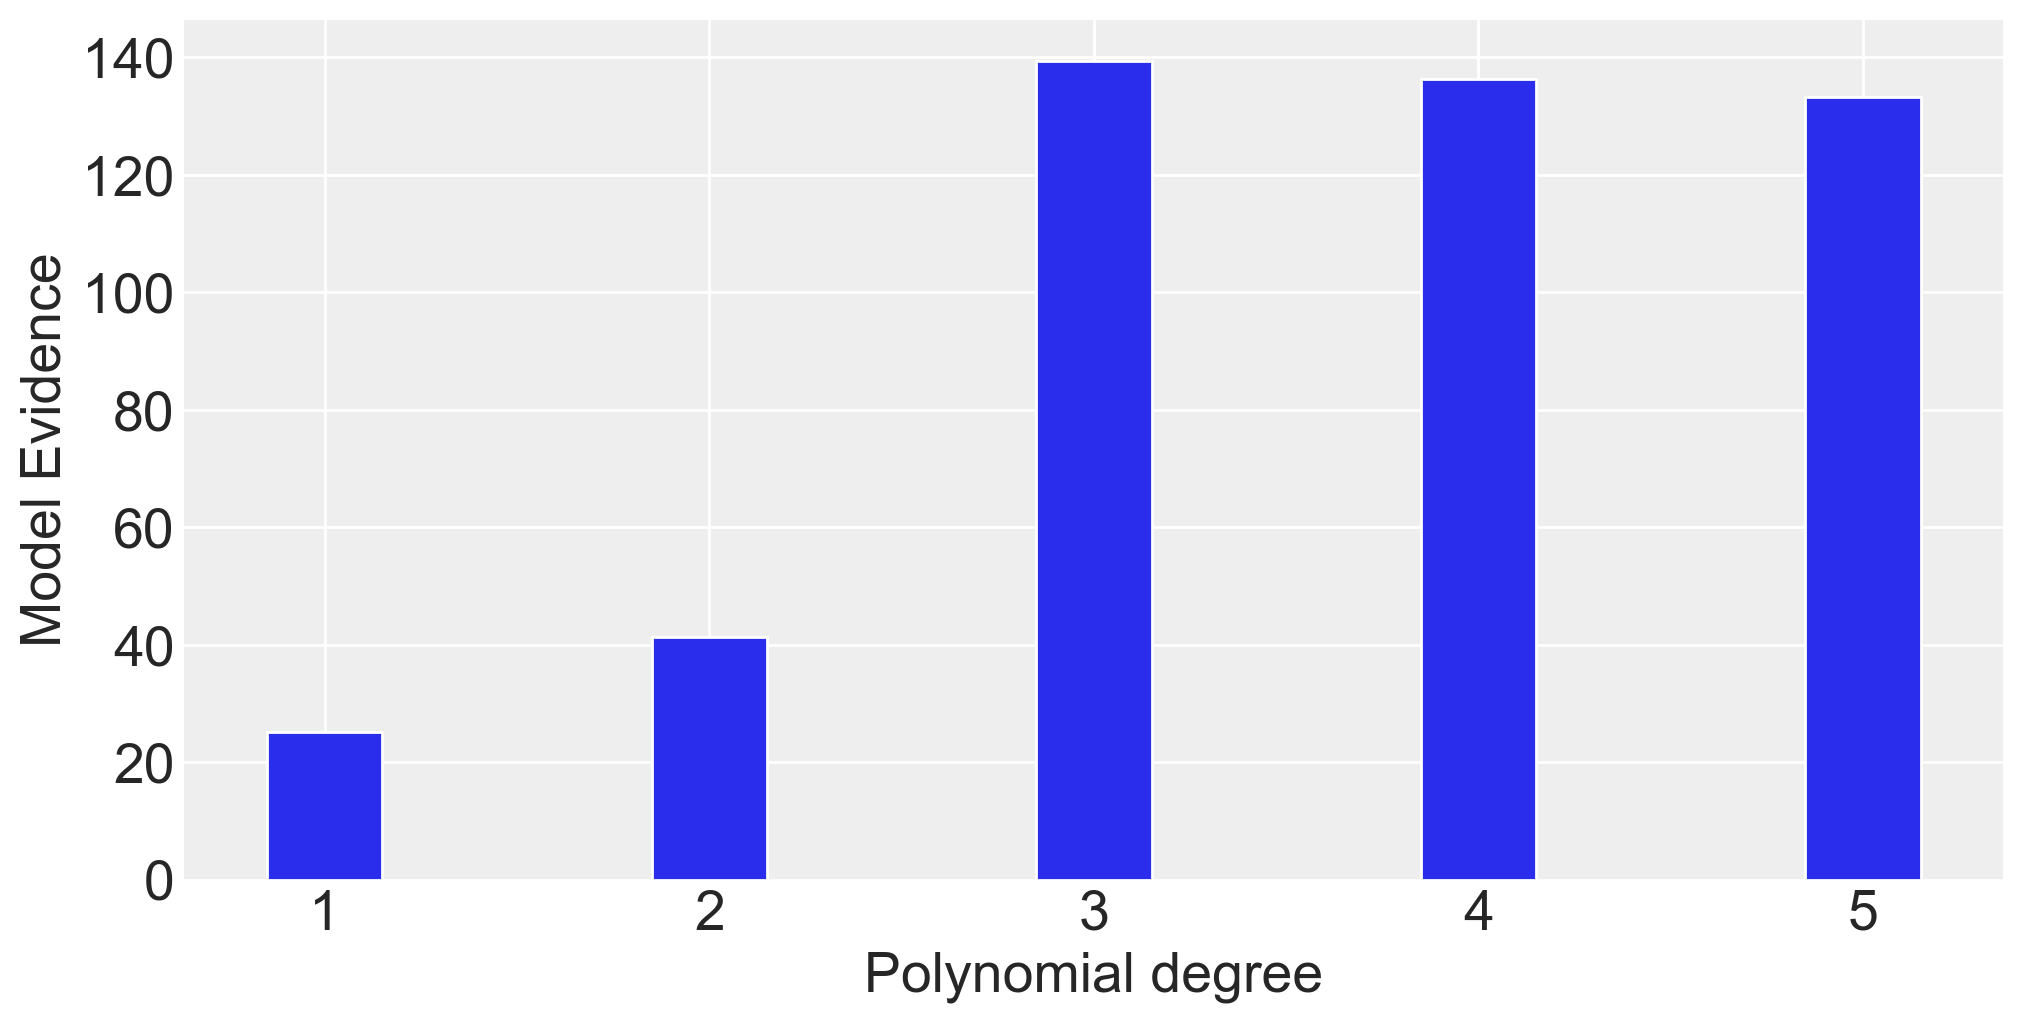

In [16]:
plt.figure(figsize=(10, 5))
_=plt.bar(D, log_Zs, width=0.3)
_=plt.xticks(D)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Polynomial degree', fontsize=20)
plt.ylabel('Model Evidence', fontsize=20);

## Questions
+ The model with degree 3 polynomials has the gradest evidence. However, the degree 4 and 5 seem also very plausible. Is this a problem for the theory of Bayesian model selection? What complicates things here, is that model 3 is included in model 4 which is included in model 5. This requires us to design special priors for the models being right. They have to be consistent in some sense. For example, if model 3 is right then model 4 must be right, etc.

+ Revisit the motorcycle dataset problem. Evaluate the model evidence for a 1) Polynomial basis; 2) a Fourier basis; and 3) a Radial basis function basis.